# Import những thư viện và module cần dùng

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_confusion_matrix, accuracy_score, f1_score
from wordcloud import WordCloud,STOPWORDS
import re
import os
import string
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, Input,GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
import torch
from transformers import DistilBertTokenizer, DistilBertConfig, DistilBertModel, TFDistilBertModel
from tqdm import tqdm
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


# Đọc dữ liệu từ file csv

In [2]:
TRAIN_FILE_PATH = '/kaggle/input/ag-news-classification-dataset/train.csv'
TEST_FILE_PATH = '/kaggle/input/ag-news-classification-dataset/test.csv'
data = pd.read_csv(TRAIN_FILE_PATH)
testdata = pd.read_csv(TEST_FILE_PATH)

train = data['Title'] + " " + data['Description'] # Combine title and description (better accuracy than using them as separate features)
y_train = data['Class Index'].apply(lambda x: x-1).values # Class labels need to begin from 0

test = testdata['Title'] + " " + testdata['Description'] # Combine title and description (better accuracy than using them as separate features)
y_test = testdata['Class Index'].apply(lambda x: x-1).values # Class labels need to begin from 0

data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


# Thăm dò và trực quan hóa dữ liệu

Thống kê số nhãn có trên tập train và tập test

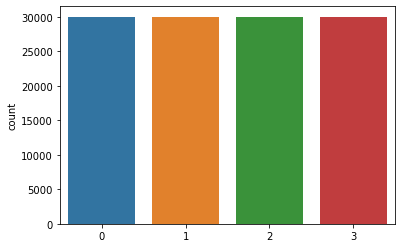

In [3]:
sns.countplot(y_train)

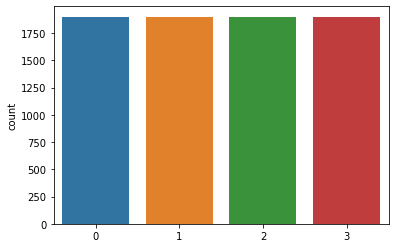

In [4]:
sns.countplot(y_test)

Có thể thấy số nhãn trên cả 2 tập data khá đồng đều. Sử dụng Word Cloud để Visualize một số từ xuất hiện nhiều trong 2 tập này để xem xu hướng của 2 tập:

## World News Wordcloud ##

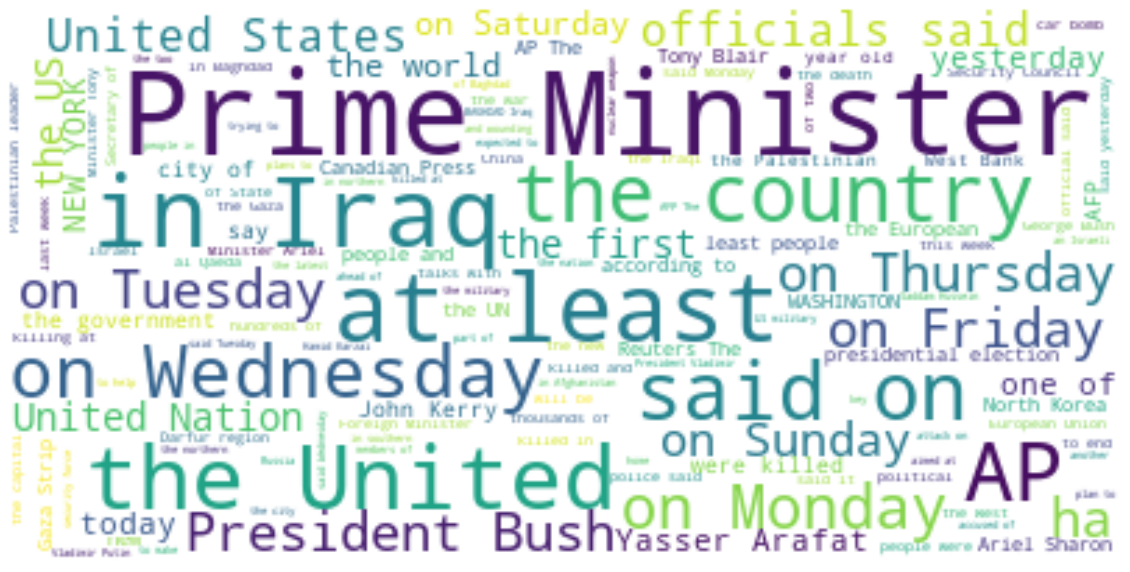

In [5]:
# Thêm một số stopwords tồn tại trong dữ liệu
stopwordset= set(STOPWORDS)
# lấy ra các tin tức chủ đề World
world = data[data['Class Index']==1]
# Vẽ biểu đồ wordcloud cho chủ đề word
plt.figure(figsize = (20,12))
wordcloud = WordCloud(max_words = 500 ,background_color="white", stopwords=stopwordset).generate(' '.join(world.Description))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sports News Wordcloud##

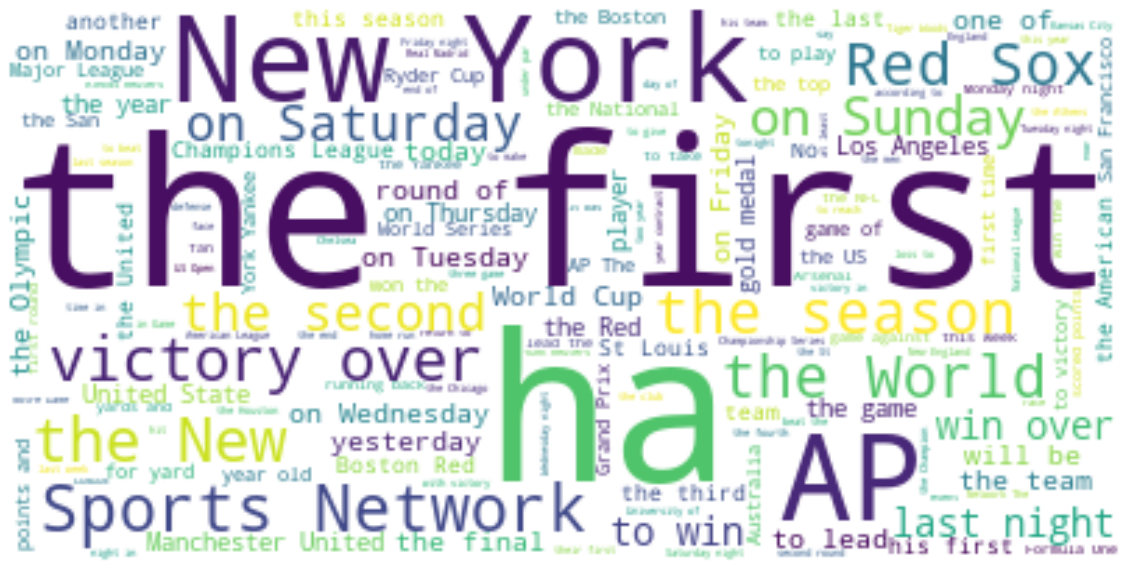

In [6]:
sports = data[data['Class Index']==2]
# Visualize with word cloud
plt.figure(figsize = (20,12))
wordcloud = WordCloud(max_words = 500 ,background_color="white", stopwords=stopwordset).generate(' '.join(sports.Description))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Business News Wordcloud ##

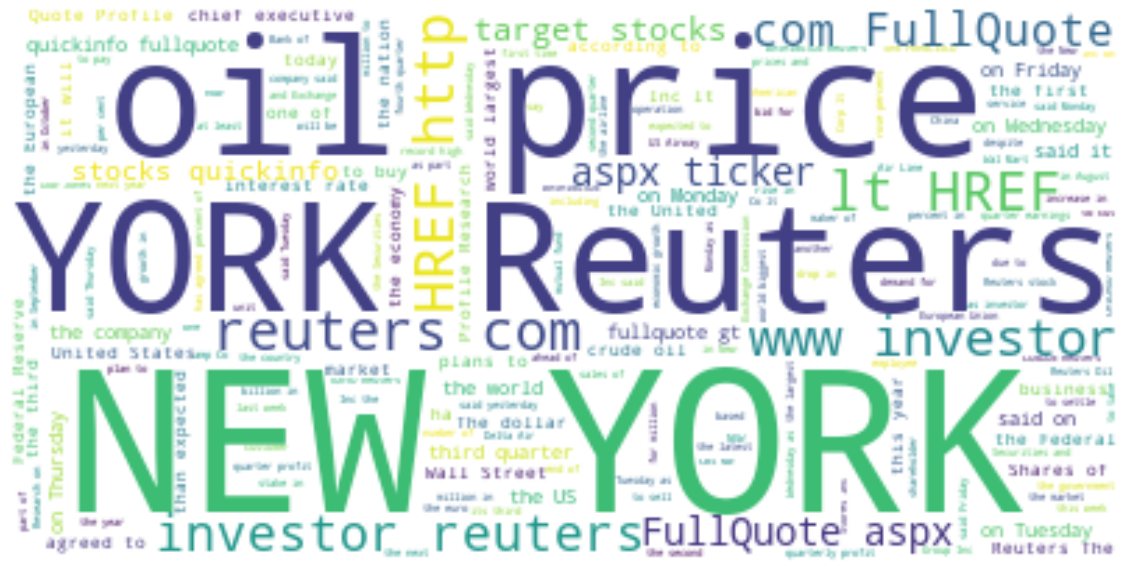

In [7]:
business = data[data['Class Index']==3]
# Visualize with word cloud
plt.figure(figsize = (20,12))
wordcloud = WordCloud(max_words = 500 ,background_color="white", stopwords=stopwordset).generate(' '.join(business.Description))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Science and Technology News Wordcloud ##

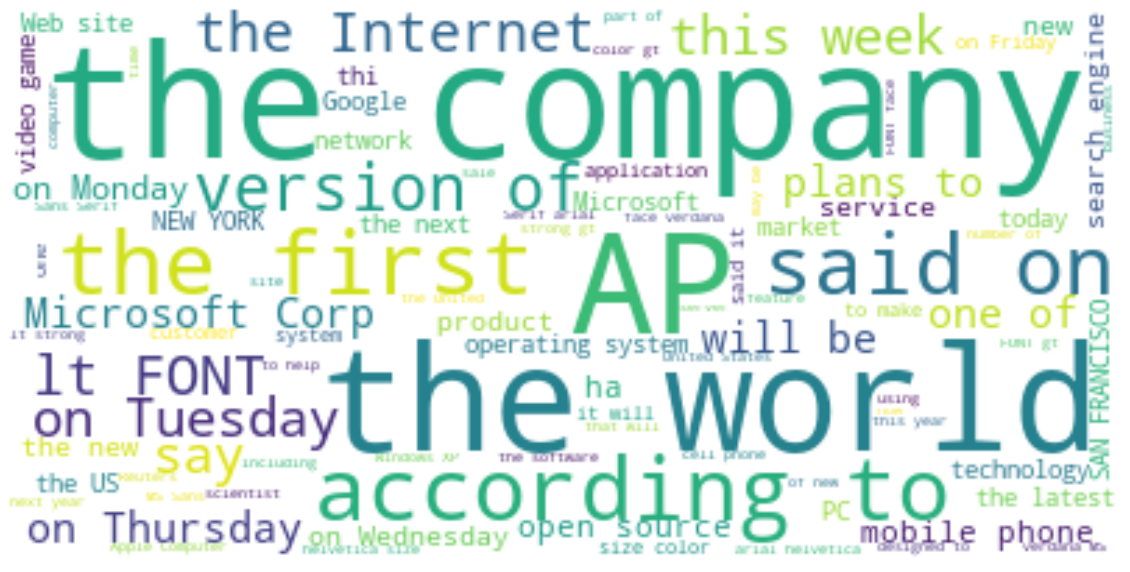

In [8]:
SnT = data[data['Class Index']==4]
# Visualize with word cloud
plt.figure(figsize = (20,12))
wordcloud = WordCloud(max_words = 500 ,background_color="white", stopwords=stopwordset).generate(' '.join(SnT.Description))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Tiền xử lí dữ liệu #

In [9]:
# Sử dụng Regular Expression lọc các url tồn tại trong dataset
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

X_train = train.apply(remove_urls)
X_test = test.apply(remove_urls)

In [10]:
# Sử dụng Regular Expression lọc các thẻ html tồn tại trong dataset
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

X_train = X_train.apply(remove_html)
X_test = X_test.apply(remove_html)

In [11]:
# Tách các phần tử trong câu ra thành từng phần riêng biệt
def word_tokenize(txt):
    tokens = re.findall("[\w']+", txt)
    return tokens
X_train = X_train.apply(word_tokenize)
X_test = X_test.apply(word_tokenize)

In [12]:
# Chuyển tất cả các từ trong dataset về dạng viết thường
def lowercasing(lst):
    new_lst=[]
    for  i in  lst:
        i=i.lower()
        new_lst.append(i) 
    return new_lst
X_train = X_train.apply(lowercasing)
X_test = X_test.apply(lowercasing)

In [13]:
# Tiến hành lọc bỏ các từ không có nhiều ý nghĩa trong tiếng Anh (stopwords) như a, an, the, and, but, ...
def remove_stopwords(lst):
    stop=stopwords.words('english')
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

X_train=X_train.apply(remove_stopwords)
X_test=X_test.apply(remove_stopwords)

In [14]:
# Loại bỏ các kí tự đặc biệt trong văn bản
def remove_punctuations(lst):
    new_lst=[]
    for i in lst:
        for j in  string.punctuation:
            i=i.replace(j,'')
        new_lst.append(i)
    return new_lst
X_train = X_train.apply(remove_punctuations) 
X_test = X_test.apply(remove_punctuations)

In [15]:
# Loại bỏ các tiền tố hậu tố trong văn bản
# Ex: Playing -> play
#     Played -> play
def stemming(text):
    porter_stemmer = PorterStemmer()
    roots = [porter_stemmer.stem(each) for each in text]
    return (roots)

X_train=X_train.apply(stemming)
X_test=X_test.apply(stemming)

In [16]:
# Chuyển các từ đặc biệt về dạng nguyên mẫu
#Ex: are/is/am -> be
lemmatizer=WordNetLemmatizer()
def lemmatzation(lst):
    new_lst=[]
    for i in lst:
        i=lemmatizer.lemmatize(i)
        new_lst.append(i)
    return new_lst
X_train=X_train.apply(lemmatzation)
X_test=X_test.apply(lemmatzation)

In [17]:
# Lọc thêm một số stopword chỉ xuất hiện trong dataset
def remove_extrawords(lst):
    stop=['href','lt','gt','ii','iii','ie','quot','com']
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

X_train=X_train.apply(remove_extrawords)
X_test=X_test.apply(remove_extrawords)

In [18]:
# Gộp các tokens lại thành một câu
X_train=X_train.apply(lambda x: ''.join(i+' ' for i in x))
X_test=X_test.apply(lambda x: ''.join(i+' '  for i in x))

# Biến đổi dữ liệu từ text sang vector

In [19]:
"""Sử dụng Tf-idf để tính toán vectorize dữ liệu (RAW). Vì dữ liệu tương đối lớn nên để giới hạn số cột và thông tin, 
ta giới hạn số feature tối đa là 1000 và không onehot dữ liệu như thông thường mà chuyển về miền dữ liệu """ 
tfidf=TfidfVectorizer(max_features=1000,min_df=6)
X_raw_train_arr=tfidf.fit_transform(train)
X_raw_test_arr=tfidf.transform(test)
print(len(tfidf.get_feature_names()))
X_raw_train_arr=X_raw_train_arr.toarray()
X_raw_test_arr=X_raw_test_arr.toarray()

1000


In [20]:
"""Sử dụng Tf-idf để tính toán vectorize dữ liệu (đã được xử lí). Vì dữ liệu tương đối lớn nên để giới hạn số cột và thông tin, 
ta giới hạn số feature tối đa là 1000 và không onehot dữ liệu như thông thường mà chuyển về miền dữ liệu """ 
tfidf=TfidfVectorizer(max_features=1000,min_df=6)
X_train_arr=tfidf.fit_transform(X_train)
X_test_arr=tfidf.transform(X_test)
print(len(tfidf.get_feature_names()))
X_train_arr=X_train_arr.toarray()
X_test_arr=X_test_arr.toarray()

1000


# Sử dụng mô hình Machine Learning ( mặc định ) và sử dụng dữ liệu thô (RAW Data)

In [21]:
# Hàm dùng để trực quang confusion matrix
def confusion_mat(color):
    cof=confusion_matrix(y_test, y_pred)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

Accuracy on Train set:  82.26 %
Accuracy on Test set:  81.32000000000001 %
F1:  0.8131578947368422


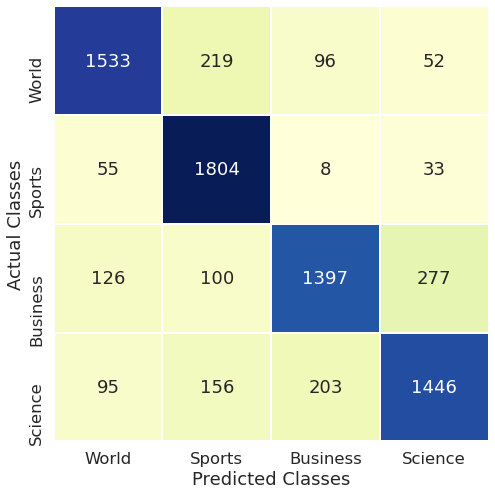

In [22]:
# Sử dụng mô hình Gaussian Naive Bayes để train dữ liệu
model = GaussianNB()
model.fit(X_raw_train_arr, y_train)
# Kết quả đánh giá mô hình trên tập test
y_pred = model.predict(X_raw_test_arr)
print('Accuracy on Train set: ', round(accuracy_score(y_train,model.predict(X_raw_train_arr)),4)*100,'%')
print('Accuracy on Test set: ', round(accuracy_score(y_test,y_pred),4)*100,'%')
print('F1: ', f1_score(y_test,y_pred,average='micro'))

confusion_mat('YlGnBu')

Accuracy on Train set:  85.32 %
Accuracy on Test set:  84.47 %
F1:  0.8447368421052631


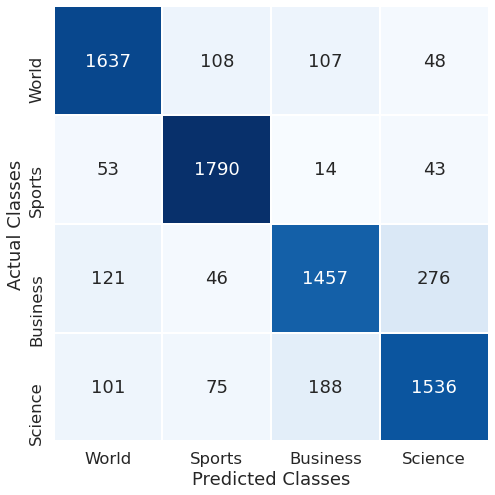

In [23]:
# Sử dụng mô hình Multinomial Naive Bayes để train dữ liệu
model = MultinomialNB()
model.fit(X_raw_train_arr, y_train)
# Kết quả đánh giá mô hình trên tập test
y_pred = model.predict(X_raw_test_arr)
print('Accuracy on Train set: ', round(accuracy_score(y_train,model.predict(X_raw_train_arr)),4)*100,'%')
print('Accuracy on Test set: ', round(accuracy_score(y_test,y_pred),4)*100,'%')
print('F1: ', f1_score(y_test,y_pred,average='micro'))

confusion_mat('Blues')

# Sử dụng mô hình Machine Learning ( hyperparameter tuning ) và sử dụng dữ liệu đã được xử lí

Accuracy on Train set:  84.92 %
Accuracy on Test set:  84.05 %
F1:  0.8405263157894737


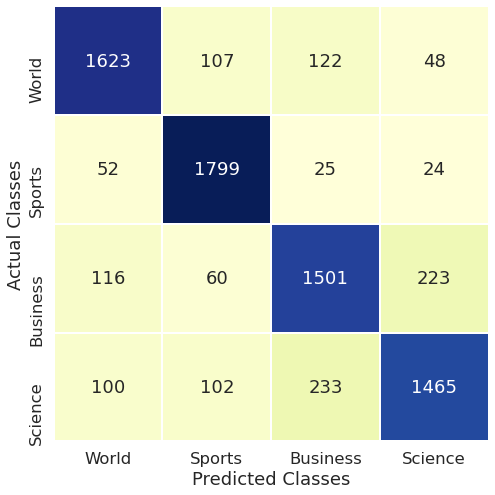

In [24]:
# Sử dụng mô hình Gaussian Naive Bayes để train dữ liệu (th)
model = GaussianNB(var_smoothing=0.06)
model.fit(X_train_arr, y_train)
# Kết quả đánh giá mô hình trên tập test
y_pred = model.predict(X_test_arr)
print('Accuracy on Train set: ', round(accuracy_score(y_train,model.predict(X_train_arr)),4)*100,'%')
print('Accuracy on Test set: ', round(accuracy_score(y_test,y_pred),4)*100,'%')
print('F1: ', f1_score(y_test,y_pred,average='micro'))

confusion_mat('YlGnBu')

Thay đổi tham số **var_smoothing** từ 1e-9 tăng lên 0.06 và tiền xử lí dữ liệu -> Accuracy trên tập test tăng từ 81.32% lên 84.05%

Accuracy on Train set:  86.18 %
Accuracy on Test set:  85.47 %
F1:  0.8547368421052631


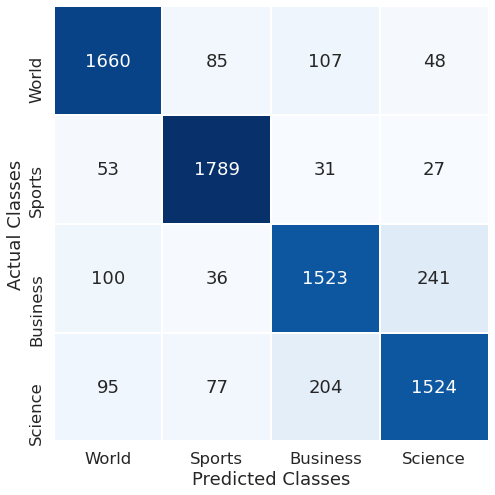

In [25]:
# Sử dụng mô hình Multinomial Naive Bayes để train dữ liệu
model = MultinomialNB(alpha=5.7)
model.fit(X_train_arr, y_train)
# Kết quả đánh giá mô hình trên tập test
y_pred = model.predict(X_test_arr)
print('Accuracy on Train set: ', round(accuracy_score(y_train,model.predict(X_train_arr)),4)*100,'%')
print('Accuracy on Test set: ', round(accuracy_score(y_test,y_pred),4)*100,'%')
print('F1: ', f1_score(y_test,y_pred,average='micro'))

confusion_mat('Blues')

Thay đổi tham số **alpha** từ 1 tăng lên 5.7 và tiền xử lí dữ liệu -> Accuracy trên tập test tăng từ 84.47% lên 85.47%

# Sử dụng Pre-trained  DistilBERT để tokenize và Fine-tuning cho bài toán Text Classification

Sử dụng Distil BERT Tokenizer để tokenize dữ liệu

In [26]:
# Sử dụng DistilBERT Pre-trained model để tokenize data
maxlen = train.map(lambda x: len(x.split())).max()
distil_bert = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=maxlen, pad_to_max_length=True, truncation=True)

def tokenize(sentences, tokenizer, maxlen):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [ ]:
Playing => Play ##ing

Tokenize dữ liệu chưa được xử lí với Distil BERT tokenizer

In [27]:
X_raw_train = tokenize(train, tokenizer, maxlen)
X_raw_test = tokenize(test, tokenizer, maxlen)

100%|██████████| 7600/7600 [00:14<00:00, 514.77it/s]


In [28]:
np.array(X_raw_train).shape

(3, 120000, 177)

In [29]:
with tpu_strategy.scope():
    config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config=config)

    input_ids_in = Input(shape=(maxlen,), name='input_token', dtype='int32')
    input_masks_in = Input(shape=(maxlen,), name='masked_token', dtype='int32') 

    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    X = Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
    X = GlobalMaxPool1D()(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(4, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
        layer.trainable = False

    model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 177)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 177)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 177, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 177, 128)     426496      tf_distil_bert_model[0][0]       
_____________________________________________________________________________________________

In [30]:
callbacks = [
#     EarlyStopping(
#         monitor='val_accuracy',
#         min_delta=1e-4,
#         patience=4,
#         verbose=1
#     ),
    ModelCheckpoint(
        filepath='DistilBERT_RAW.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [31]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_raw_train, y_train, batch_size=64 * tpu_strategy.num_replicas_in_sync, validation_data=(X_raw_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8846
Epoch 00001: val_accuracy improved from -inf to 0.91605, saving model to DistilBERT_RAW.h5
235/235 [==============================] - 56s 238ms/step - loss: 0.3498 - accuracy: 0.8846 - val_loss: 0.2380 - val_accuracy: 0.9161
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9148
Epoch 00002: val_accuracy improved from 0.91605 to 0.92013, saving model to DistilBERT_RAW.h5
235/235 [==============================] - 25s 107ms/step - loss: 0.2403 - accuracy: 0.9148 - val_loss: 0.2259 - val_accuracy: 0.9201
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9250
Epoch 00003: val_accuracy improved from 0.92013 to 0.93079, saving model to DistilBERT_RAW.h5
235/235 [==============================] - 25s 107ms/step - loss: 0.2136 - accuracy: 0.9250 - val_loss: 0.1977 - val_accuracy: 0.9308
Epoch 4/20
235/235 [===========

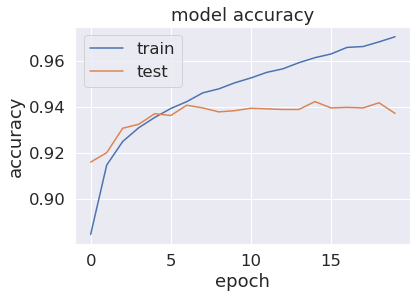

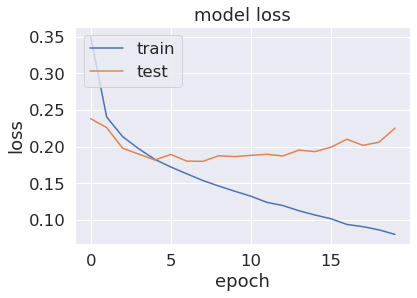

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Accuracy on Train set:  97.45 %
Accuracy on Test set:  94.21000000000001 %
F1:  0.9421052631578948


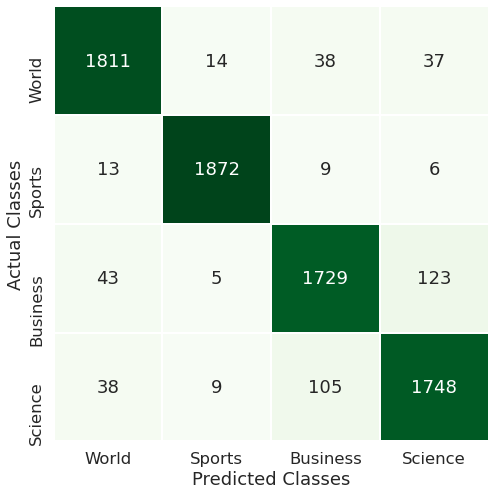

In [33]:
model.load_weights('DistilBERT_RAW.h5')
y_pred = np.argmax(model.predict(X_raw_test), axis=1)
print('Accuracy on Train set: ', round(accuracy_score(y_train,np.argmax(model.predict(X_raw_train), axis=1)),4)*100,'%')
print('Accuracy on Test set: ', round(accuracy_score(y_test,y_pred),4)*100,'%')
print('F1: ', f1_score(y_test,y_pred,average='micro'))

confusion_mat('Greens')

Thực hiện tokenize và train với dữ liệu đã xử lí để so sánh ( cùng số batch size, epochs )

In [34]:
maxlen = X_train.map(lambda x: len(x.split())).max()

In [35]:
X_train = tokenize(X_train, tokenizer, maxlen)
X_test = tokenize(X_test, tokenizer, maxlen)

100%|██████████| 7600/7600 [00:10<00:00, 712.96it/s]


In [36]:
np.array(X_train).shape

(3, 120000, 113)

In [37]:
callbacks = [
#     EarlyStopping(
#         monitor='val_accuracy',
#         min_delta=1e-4,
#         patience=4,
#         verbose=1
#     ),
    ModelCheckpoint(
        filepath='DistilBERT_PRP.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [38]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64 * tpu_strategy.num_replicas_in_sync, validation_data=(X_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.8931
Epoch 00001: val_accuracy improved from -inf to 0.90842, saving model to DistilBERT_PRP.h5
235/235 [==============================] - 41s 176ms/step - loss: 0.3098 - accuracy: 0.8931 - val_loss: 0.2770 - val_accuracy: 0.9084
Epoch 2/20
234/235 [============================>.] - ETA: 0s - loss: 0.2661 - accuracy: 0.9065
Epoch 00002: val_accuracy improved from 0.90842 to 0.91211, saving model to DistilBERT_PRP.h5
235/235 [==============================] - 17s 72ms/step - loss: 0.2659 - accuracy: 0.9066 - val_loss: 0.2632 - val_accuracy: 0.9121
Epoch 3/20
234/235 [============================>.] - ETA: 0s - loss: 0.2469 - accuracy: 0.9128
Epoch 00003: val_accuracy improved from 0.91211 to 0.91592, saving model to DistilBERT_PRP.h5
235/235 [==============================] - 17s 72ms/step - loss: 0.2469 - accuracy: 0.9128 - val_loss: 0.2588 - val_accuracy: 0.9159
Epoch 4/20
234/235 [=============

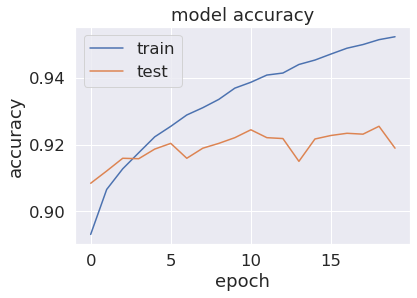

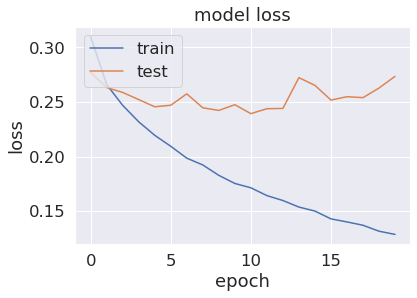

In [39]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Accuracy on Train set:  97.26 %
Accuracy on Test set:  92.57 %
F1:  0.9256578947368422


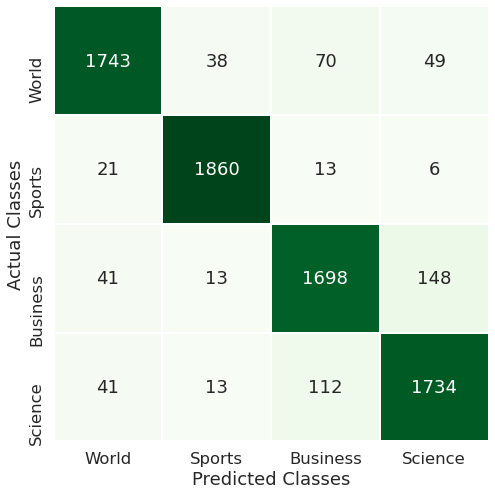

In [40]:
model.load_weights('DistilBERT_PRP.h5')
y_pred = np.argmax(model.predict(X_test), axis=1)
print('Accuracy on Train set: ', round(accuracy_score(y_train,np.argmax(model.predict(X_train), axis=1)),4)*100,'%')
print('Accuracy on Test set: ', round(accuracy_score(y_test,y_pred),4)*100,'%')
print('F1: ', f1_score(y_test,y_pred,average='micro'))

confusion_mat('Greens')

Thực nghiệm đối với Pre-trained DistilBERT lên 2 tập dữ liệu ta lại thấy kết quả khác là kết quả đánh giá mô hình dự đoán trên dữ liệu đã được xử lí thấp hơn đối với dữ liệu chưa được xử lí cũng là một kết quả dễ hiểu vì theo [1] thì BERT được pre-training trên dữ liệu English Wikipedia và BookCorpus, đây là những dữ liệu văn bản dưới dạng văn bản chính quy mà dữ liệu của chúng ta không phải dạng là dữ liệu này nên bước tiền xử lí có thể đã làm một số thông tin sai lệch đi ảnh hưởng đến chất lượng của dữ liệu.

# Tokenize data với DistilBERT Word Embedding và sử dụng mô hình Bi-LSTM 

Khởi tạo tham số Embedding layer cho dữ liệu tokenize bởi DistilBERT

In [41]:
def get_bert_embed_matrix():
    model = DistilBertModel.from_pretrained(distil_bert)
    bert_embeddings = list(model.children())[0]
    bert_word_embeddings = list(bert_embeddings.children())[0]
    mat = bert_word_embeddings.weight.data.numpy()
    return mat
embedding_matrix = get_bert_embed_matrix()

Xây dựng kiến trúc Bi-LSTM

In [42]:
with tpu_strategy.scope():    
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1], input_length=maxlen))
    model.add(Bidirectional(LSTM(128, return_sequences=True))) # bidirectional LSTMs since this isn't a timeseries problem
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1024))
    model.add(Dropout(0.25))
    model.add(Dense(512))
    model.add(Dropout(0.25))
    model.add(Dense(256))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation='softmax'))
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 113, 768)          23440896  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 113, 256)          918528    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 113, 128)          164352    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5

In [43]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights_RAW.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [44]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # sparse categorical crossentropy loss because data is not one-hot encoded
history = model.fit(X_raw_train, y_train, batch_size=64 * tpu_strategy.num_replicas_in_sync, validation_data=(X_raw_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.8725
Epoch 00001: val_accuracy improved from -inf to 0.91447, saving model to weights_RAW.h5
235/235 [==============================] - 20s 86ms/step - loss: 0.3481 - accuracy: 0.8725 - val_loss: 0.2459 - val_accuracy: 0.9145
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9444
Epoch 00002: val_accuracy improved from 0.91447 to 0.91816, saving model to weights_RAW.h5
235/235 [==============================] - 12s 53ms/step - loss: 0.1624 - accuracy: 0.9444 - val_loss: 0.2446 - val_accuracy: 0.9182
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.9637
Epoch 00003: val_accuracy did not improve from 0.91816
235/235 [==============================] - 12s 51ms/step - loss: 0.1047 - accuracy: 0.9637 - val_loss: 0.2824 - val_accuracy: 0.9128
Epoch 4/20
234/235 [============================>.] - ETA: 0s - loss: 0.0667 - 

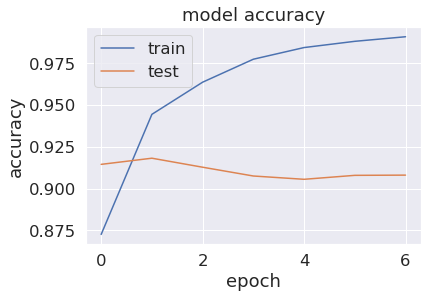

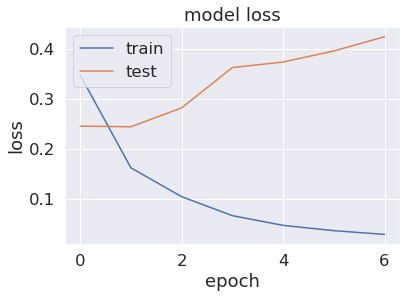

In [45]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Accuracy on Train set:  97.3 %
Accuracy on Test set:  91.82000000000001 %
F1:  0.9181578947368421


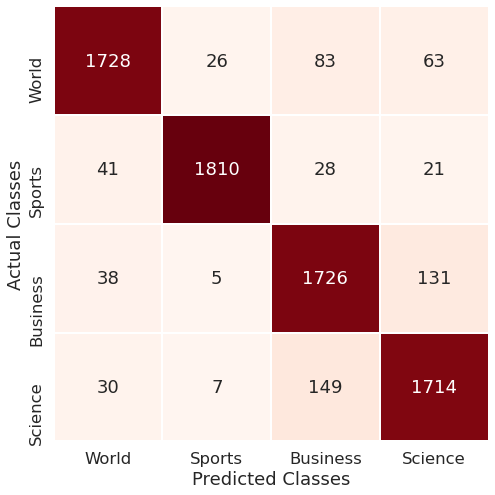

In [46]:
model.load_weights('weights_RAW.h5')
y_pred = np.argmax(model.predict(X_raw_test), axis=1)
print('Accuracy on Train set: ', round(accuracy_score(y_train,np.argmax(model.predict(X_raw_train), axis=1)),4)*100,'%')
print('Accuracy on Test set: ', round(accuracy_score(y_test,y_pred),4)*100,'%')
print('F1: ', f1_score(y_test,y_pred,average='micro'))

confusion_mat('Reds')

In [47]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights_PRP.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [48]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # sparse categorical crossentropy loss because data is not one-hot encoded
history = model.fit(X_train, y_train, batch_size=64 * tpu_strategy.num_replicas_in_sync, validation_data=(X_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9197
Epoch 00001: val_accuracy improved from -inf to 0.91303, saving model to weights_PRP.h5
235/235 [==============================] - 16s 69ms/step - loss: 0.2297 - accuracy: 0.9197 - val_loss: 0.2684 - val_accuracy: 0.9130
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9487
Epoch 00002: val_accuracy did not improve from 0.91303
235/235 [==============================] - 10s 41ms/step - loss: 0.1473 - accuracy: 0.9487 - val_loss: 0.2890 - val_accuracy: 0.9101
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9650
Epoch 00003: val_accuracy did not improve from 0.91303
235/235 [==============================] - 10s 41ms/step - loss: 0.0976 - accuracy: 0.9650 - val_loss: 0.3263 - val_accuracy: 0.9047
Epoch 4/20
235/235 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9752
Epoch 00004: val_ac

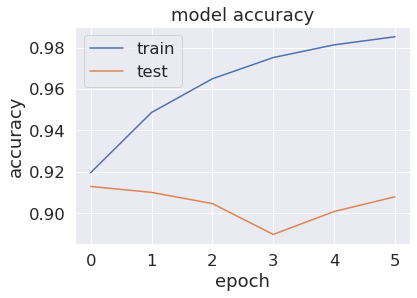

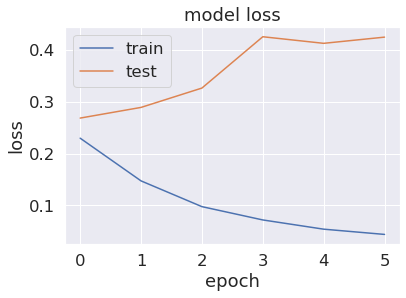

In [49]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Accuracy on Train set:  95.5 %
Accuracy on Test set:  91.3 %
F1:  0.9130263157894737


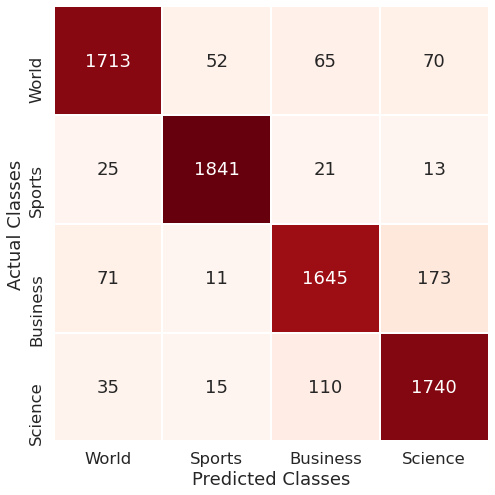

In [50]:
model.load_weights('weights_PRP.h5')
y_pred = np.argmax(model.predict(X_test), axis=1)
print('Accuracy on Train set: ', round(accuracy_score(y_train,np.argmax(model.predict(X_train), axis=1)),4)*100,'%')
print('Accuracy on Test set: ', round(accuracy_score(y_test,y_pred),4)*100,'%')
print('F1: ', f1_score(y_test,y_pred,average='micro'))

confusion_mat('Reds')